# Building NeutralScore, a classification Model for non-toxic versus toxic detection.

We'll build a classification model using Kaggle Jigsaw Toxic Classification dataset to classify if a post is non-toxic or toxic. The result of this classification model will be used as an evaluating metric for our Style Transfer model. 



## 1. Set up

In [1]:
# !pip install -q transformers nlpaug

In [1]:
#Am I running a GPU and what type is it?
!nvidia-smi

Mon Mar 27 02:39:44 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   49C    P8    16W /  70W |      2MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch

if torch.cuda.is_available():     
    # device = torch.device("cuda")
    device = "cuda"
    print('Number of GPU(s) available:', torch.cuda.device_count())
    print('GPU device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available')
    # device = torch.device("cpu")
    device = "cpu"

Number of GPU(s) available: 1
GPU device name: Tesla T4


In [3]:
from logging import warning
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler, TensorDataset
import torch.backends.cudnn as cudnn
import torch.optim as optim

from transformers import BertTokenizer, BertModel, DistilBertTokenizer, DistilBertModel

from sklearn.utils import resample
from sklearn.model_selection import train_test_split

import re
import random
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pprint
import os
import shutil
import time
import datetime


import warnings
warnings.filterwarnings('ignore')


In [4]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [6]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd ..
# cd drive/MyDrive/w266/style_transfer_w266/

/home/ubuntu/style_transfer_w266


## 2.EDA & Data Preprocessing

We could see that the jigsaw data split the toxic comments into different categories. For our model, we will include all of these categories into a toxic category:
 - toxic
 - severe_toxic
 - obscene
 - threat
 - insult
 - identity_hate

 Our model goal is to classify if a post is non-toxic (label = 1) versus toxic (label = 0), which could be used as a NonToxicScore metric.

In [6]:
text_file = 'data/jigsaw_classification_data.csv'
df = pd.read_csv(text_file)
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [7]:
# EDA
print('Count of toxic:')
print(df.toxic.value_counts())

print('\nCount of severe toxic:')
print(df.severe_toxic.value_counts())

print('\nCount of obscene:')
print(df.obscene.value_counts())

print('\nCount of threat:')
print(df.threat.value_counts())

print('\nCount of insult:')
print(df.insult.value_counts())

print('\nCount of identity hate:')
print(df.identity_hate.value_counts())

Count of toxic:
0    144277
1     15294
Name: toxic, dtype: int64

Count of severe toxic:
0    157976
1      1595
Name: severe_toxic, dtype: int64

Count of obscene:
0    151122
1      8449
Name: obscene, dtype: int64

Count of threat:
0    159093
1       478
Name: threat, dtype: int64

Count of insult:
0    151694
1      7877
Name: insult, dtype: int64

Count of identity hate:
0    158166
1      1405
Name: identity_hate, dtype: int64


In [8]:
# Create a label column with 0 = toxic, 1 = non-toxic
df['label'] = (df.toxic + df.severe_toxic + df.obscene + df.threat + df.insult + df.identity_hate) == 0
df['label'] = df['label'].astype(int)
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,label
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1


In [9]:
# Count toxic & non-toxic labels 
print('\nCount of non_toxic labels:')
print(df.label.value_counts())


Count of non_toxic labels:
1    143346
0     16225
Name: label, dtype: int64


In [12]:
def modify_text_to_print(df_original, column="comment_text"):
  """Modify some toxic, offensive texts in the dataframe for printing out"""
  df = df_original.copy()
  df[column] = df[column].apply(lambda x: x.lower().replace('fuck', 'f***')\
                              .replace('shit', 's***')\
                              .replace('rape', 'r***')\
                              .replace('penis', 'p***')\
                              .replace('dick', 'd***'))

  return df

In [15]:
## Perform under_sampling to create balance the dataset
# Change majority class (non-toxic) to minority ~66%
# Change minority class (toxic) to majority ~33%
# Separate majority and minority classes
df_majority = df[df["label"] == 1]
df_minority = df[df["label"] == 0]

# Undersample majority class
df_majority_downsampled = resample(df_majority,
                                   replace=False,     # sample without replacement
                                   n_samples=round(len(df_minority)),    # change majority to minority clas
                                   random_state=42) 

# Combine minority class and downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

# Shuffle the rows
df_downsampled = df_downsampled.sample(frac=1, random_state=42).reset_index(drop=True)

# Count toxic & non-toxic labels for downsampled dataframe
print('\nCount of non_toxic labels:')
print(df_downsampled.label.value_counts())

modify_text_to_print(df_downsampled)


Count of non_toxic labels:
1    16225
0    16225
Name: label, dtype: int64


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,label
0,736b2e14e4601fbe,we want to keep the first sentence of the lead...,0,0,0,0,0,0,1
1,7822ae6443c5e793,who cares.... goethean is a capuchin monkeys a...,1,0,0,0,0,0,0
2,838a0ed57bc52ee3,yes i would say the book source is enough to a...,0,0,0,0,0,0,1
3,accede373132c680,thanks for your help. i guess i will have to ...,0,0,0,0,0,0,1
4,a40a67134db4ea89,then do the same for the tiger accounts.,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
32445,c81e3c4002cad452,== f*** you \ni hope you die motherf***er,1,1,1,1,1,0,0
32446,47dd1a90bb3ea130,"""\n\n september 2009 \nhello, and welcome to w...",0,0,0,0,0,0,1
32447,0a760296d10de338,"welcome!\n\nhello, , and welcome to wikipedia!...",0,0,0,0,0,0,1
32448,d264b84fa1ecc882,"dear ,\n\nall three titles\n utazás faremidóba...",0,0,0,0,0,0,1


In [14]:
## Data Clean Up
def clean_up_text(x):
  """Remove line breaks, special characters, punctuations within each post"""
  # Remove special characters and punctuations
  SPECIAL_CHARS_PATTERN = re.compile(r"(\*)|(\=\=)|(\~)|(\=)|(\.\.\.)|(\;)|(\:)|(\!)|(\?)|(\,)|(\")|(\|)|(\()|(\))|(\[)|(\])|(\%)|(\$)|(\>)|(\<)|(\{)|(\})")
  x = SPECIAL_CHARS_PATTERN.sub("", x.lower())

  # Remove different types of line breaks and white spaces
  x = re.sub(r"\n|\r|\r\n|<br\s*/?>", " ", x)
  
  # Remove extra white spaces
  x = re.sub(r"\s+", " ", x.strip())

  return x

In [16]:
df_downsampled["cleaned_text"] = df_downsampled.comment_text.apply(clean_up_text)
modify_text_to_print(df_downsampled[["cleaned_text", "label"]],"cleaned_text")

,cleaned_text,label
0,we want to keep the first sentence of the lead...,1
1,who cares. goethean is a capuchin monkeys anyway,0
2,yes i would say the book source is enough to a...,1
3,thanks for your help. i guess i will have to s...,1
4,then do the same for the tiger accounts.,1
...,...,...
32445,f*** you i hope you die motherf***er,0
32446,september 2009 hello and welcome to wikipedia ...,1
32447,welcome hello and welcome to wikipedia thank y...,1
32448,dear all three titles utazás faremidóba voyage...,1


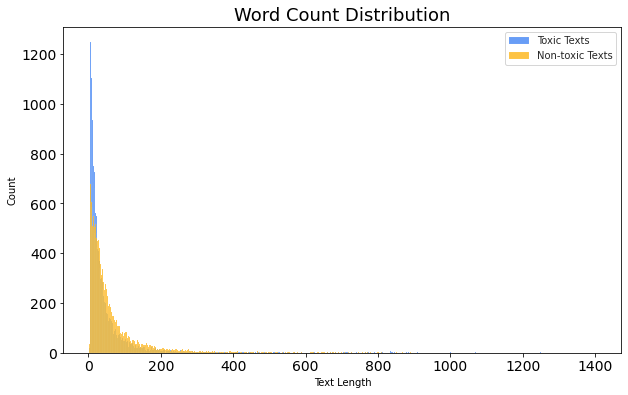

In [ ]:
# Calculate word counts
df_downsampled['word_count'] = df_downsampled['cleaned_text'].apply(lambda x: len(x.split(' ')))
df_toxic = df_downsampled[df_downsampled.label == 0]
df_nontoxic = df_downsampled[df_downsampled.label == 1]

### Plot the word-count distribution for the toxic texts and the non toxic texts.
fig, ax = plt.subplots(figsize=(10, 6))
sns.set_style('white')

# calculate the bin size based on the range of the data
bins = range(min(df_toxic['word_count'].min(), df_nontoxic['word_count'].min()), 
             max(df_toxic['word_count'].max(), df_nontoxic['word_count'].max()) + 2, 2)

# plot the histograms with the same bin size
sns.histplot(data=df_toxic, x='word_count', label='Toxic Texts', bins=bins, color='#4285F4', alpha=0.8)
sns.histplot(data=df_nontoxic, x='word_count', label='Non-toxic Texts', bins=bins, color='#FDB515', alpha=0.8)

# set the axis labels and title
ax.set(xlabel='Text Length', ylabel='Count')
ax.set_title('Word Count Distribution', fontsize=18)

# set the legend and adjust its position
plt.legend(fontsize=14)
plt.legend(loc='upper right')

# set the ticks fontsize
ax.tick_params(axis='both', which='major', labelsize=14)


In [ ]:
## Train, Val, Test Split
X_full =  df_downsampled["cleaned_text"]
y_full = df_downsampled["label"]

# Split test set
X_train_val, X_test, y_train_val, y_test = train_test_split(X_full, y_full, 
                                                            test_size=0.1,
                                                            random_state=42,
                                                            stratify=y_full
                                                            )

# Split train - dev
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, 
                                                            test_size=0.12,
                                                            random_state=42,
                                                            stratify=y_train_val
                                                            )

print('Train Data Dimension:', X_train.shape)
print('Train Label Dimension:', y_train.shape)
print('Development Data Dimension:', X_val.shape)
print('Development Label Dimension:', y_val.shape)
print('Test Data Dimension:', X_test.shape)
print('Test Label Dimension:', y_test.shape)

Train Data Dimension: (25700,)
Train Label Dimension: (25700,)
Development Data Dimension: (3505,)
Development Label Dimension: (3505,)
Test Data Dimension: (3245,)
Test Label Dimension: (3245,)


## 3. Classification Model with DistilBERT - 1 Hidden Layer & Undersampling

In [ ]:
# Clear out cuda before training
torch.cuda.empty_cache()

In [ ]:
# Load the BERT tokenizer
bert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# From the word count distribution, most posts from the pair-wise detoxify dataset are within 32 words.
max_length = 64

train_encodings = bert_tokenizer(
    list(X_train.values), 
    max_length=max_length,
    truncation=True,
    pad_to_max_length=True, 
    return_tensors='pt'
)

valid_encodings = bert_tokenizer(
    list(X_val.values), 
    max_length=max_length,
    truncation=True,
    pad_to_max_length=True, 
    return_tensors='pt'
)

test_encodings = bert_tokenizer(
    list(X_test.values), 
    max_length=max_length,
    truncation=True,
    pad_to_max_length=True, 
    return_tensors='pt'
)

train_encodings

{'input_ids': tensor([[  101,  2019, 23615,  ...,  2095,  1012,   102],
        [  101,  2016,  7716,  ...,  1018,   102,     0],
        [  101,  6616,  2378,  ...,     0,     0,     0],
        ...,
        [  101, 24264, 12458,  ...,  1013,  2027,   102],
        [  101,  7592,  1998,  ...,  1012,  3046,   102],
        [  101,  2115,  3566,  ...,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [ ]:
## HYPER-PARAMETERS BLOCKS
BATCH_SIZE = 16
LR =2e-5
WEIGHT_DECAY = 2e-4
EPOCHS = 4
HIDDEN_SIZE = 768
DROP_OUT = 0.1
WORKERS = int(os.cpu_count())

In [ ]:
## Data Loader
train_ids = train_encodings.input_ids
train_mask = train_encodings.attention_mask
train_labels = torch.tensor(y_train.values) 

val_ids = valid_encodings.input_ids
val_mask = valid_encodings.attention_mask
val_labels = torch.tensor(y_val.values)

test_ids = test_encodings.input_ids
test_mask = test_encodings.attention_mask
test_labels = torch.tensor(y_test.values)

train_dataset = TensorDataset(train_ids, train_mask, train_labels)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=WORKERS)

val_dataset = TensorDataset(val_ids, val_mask, val_labels)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=WORKERS)

test_dataset = TensorDataset(test_ids, test_mask, test_labels)
test_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=WORKERS)


In [ ]:
# BERT Model
class BertClassification(nn.Module):
    def __init__(self,output_dim=1, hidden_size=768, dropout=0.1):
        super(BertClassification, self).__init__()
        self.bert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')

        self.bert_hidden_size = self.bert_model.config.hidden_size
        self.hidden_size = hidden_size
        self.hidden_layer = nn.Linear(self.bert_hidden_size, self.hidden_size)

        self.drop_out = nn.Dropout(dropout)

        self.classification = nn.Linear(self.hidden_size, output_dim)

        self.ReLU = nn.ReLU()
        self.Sigmoid = nn.Sigmoid()
        
    def forward(self, input_ids, attention_mask):
        bert_output = self.bert_model(input_ids=input_ids, 
                                      attention_mask=attention_mask)
        
        # hidden_state = bert_output[0]
        cls_token = bert_output[0][:,0]

        hidden_ouput = self.ReLU(self.hidden_layer(cls_token))
        
        hidden_ouput = self.drop_out(hidden_ouput)
        output = self.Sigmoid(self.classification(hidden_ouput))
        output = output.flatten()

        return output

In [ ]:
# Initialize model
model = BertClassification(hidden_size=HIDDEN_SIZE, dropout=DROP_OUT)
model = model.to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Initiate loss to Binary Cross Entropy
criterion = nn.BCELoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

# Create learning rate scheduler.
T_max = EPOCHS*len(train_loader)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max)

In [47]:
def format_time(seconds):
    return str(datetime.timedelta(seconds=int(round(seconds))))

In [48]:
## Define train function
def train(train_loader, model, criterion, optimizer, verbose=True):  
    # reset total loss for each epoch
    total_loss = 0

    # switch model to train mode
    model.train()

    # start time
    t0 = time.time()

    for step, data in enumerate(train_loader): 
        # send the data to cuda device
        ids = data[0].to(device, dtype = torch.long)
        mask = data[1].to(device, dtype = torch.long)
        target = data[2].float().to(device)
    
        # compute output
        output = model(input_ids=ids, 
                      attention_mask=mask)

        # compute loss 
        loss = criterion(output, target)

        # Accumulate the training loss over all of the batches 
        total_loss += loss.item()

        # zero out gradients in the optimizer each step
        optimizer.zero_grad()

        # Report progress every 100 batches
        if step % 100 == 0 and not step == 0 and verbose==True:
            print('Batch {:>5,}  of  {:>5,}.  Loss {:0.4f}  Elapsed: {:}.'.format(
                 step, 
                 len(train_loader),
                 loss.item(),
                 format_time(time.time() - t0))) 
        
        # compute gradient and do SGD
        # backprop!
        loss.backward()
        
        # update the weights!
        optimizer.step()

        # update learning rate
        scheduler.step()

    avg_train_loss = total_loss / len(train_loader) 
    elapsed_time = time.time() - t0
    if verbose:
      print ("\nAvg Training Loss {:0.4f}, Completed in {:} \n".format(
          avg_train_loss,
          format_time(elapsed_time)
            ))
    
    # return model, avg_train_loss, elapsed_time
    return avg_train_loss, elapsed_time

In [49]:
## Define validate function
def validate(val_loader, model, criterion, verbose=True):
    # Initialize
    targets=[]
    outputs=[]
    t0 = time.time()
    total_val_loss = 0

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        for step, data in enumerate(val_loader):
            
            # send the data to cuda device
            ids = data[0].to(device, dtype = torch.long)
            mask = data[1].to(device, dtype = torch.long)
            target = data[2].float().to(device)

            # compute output
            output = model(input_ids=ids,
                           attention_mask=mask)

            # compute loss
            loss = criterion(output, target)

            # Accumulate the validation loss over all of the batches to calculate average loss
            total_val_loss += loss.item()

            targets.extend(target.cpu().detach().numpy().tolist())
            outputs.extend(output.cpu().detach().numpy().tolist())

            if step % 100 == 0 and not step == 0 and verbose==True:
                print('Batch {:>5,}  of  {:>5,}.  Loss {:0.4f}  Elapsed: {:}.'.format(
                    step, 
                    len(val_loader),
                    loss.item(),
                    format_time(time.time() - t0)))        

    avg_val_loss = total_val_loss / len(val_loader)
    elapsed_time = time.time() - t0
    if verbose:
      print ("\nAvg Validation Loss {:0.4f}, Completed in {:}".format(
          avg_val_loss,
          format_time(elapsed_time)
            ))
    
    return outputs, targets, avg_val_loss, elapsed_time


In [50]:
# calculate the F1 score, auc, accuracy of our predictions vs labels
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score

def compute_metrics(outputs, targets):
    y_pred = (np.array(outputs) >= 0.5).astype(float)
    y_true = np.array(targets)

    # metrics
    f1 = f1_score(y_true= y_true, y_pred=y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    # accuracy = np.sum(y_pred == y_true) / len(y_true)

    print ("F1 Score {:0.4f}, ROC AUC {:0.4f}, Accuracy {:0.4f} \n".format(f1, roc_auc, accuracy))
    
    return f1, roc_auc, accuracy

In [ ]:
# Store the average loss after each epoch so we can plot them.
train_loss_values = []
val_loss_values = []

for epoch in range(EPOCHS):
    print ('######  Epoch {}/{} ######'.format(epoch+1, EPOCHS))
    print ('-----  Training -----')
    train_loss, train_time = train(train_loader, model, criterion, optimizer)
    train_loss_values.append(train_loss)

    print ('-----  Validation -----')
    val_outputs, val_targets, val_loss, val_time = validate(val_loader, model, criterion)
    val_loss_values.append(val_loss)
    val_f1, val_roc_auc, val_accuracy = compute_metrics(val_outputs, val_targets)


######  Epoch 1/4 ######
-----  Training -----
Batch   100  of  1,607.  Loss 0.2415  Elapsed: 0:00:11.
Batch   200  of  1,607.  Loss 0.1343  Elapsed: 0:00:21.
Batch   300  of  1,607.  Loss 0.0687  Elapsed: 0:00:31.
Batch   400  of  1,607.  Loss 0.1819  Elapsed: 0:00:41.
Batch   500  of  1,607.  Loss 0.0646  Elapsed: 0:00:51.
Batch   600  of  1,607.  Loss 0.1945  Elapsed: 0:01:02.
Batch   700  of  1,607.  Loss 0.2496  Elapsed: 0:01:12.
Batch   800  of  1,607.  Loss 0.3159  Elapsed: 0:01:22.
Batch   900  of  1,607.  Loss 0.0408  Elapsed: 0:01:32.
Batch 1,000  of  1,607.  Loss 0.1136  Elapsed: 0:01:43.
Batch 1,100  of  1,607.  Loss 0.4201  Elapsed: 0:01:53.
Batch 1,200  of  1,607.  Loss 0.0943  Elapsed: 0:02:03.
Batch 1,300  of  1,607.  Loss 0.1677  Elapsed: 0:02:15.
Batch 1,400  of  1,607.  Loss 0.2138  Elapsed: 0:02:26.
Batch 1,500  of  1,607.  Loss 0.1142  Elapsed: 0:02:36.
Batch 1,600  of  1,607.  Loss 0.3076  Elapsed: 0:02:46.

Avg Training Loss 0.2205, Completed in 0:02:47 

-----  

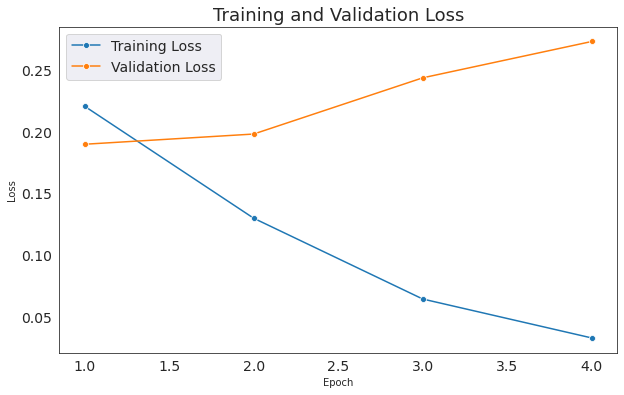

In [ ]:
### Plot Training & Validation Loss
data = {'Epoch': range(1, 5), 'Training Loss': train_loss_values, 'Validation Loss': val_loss_values}
df = pd.DataFrame(data)

fig, ax = plt.subplots(figsize=(10, 6))
sns.set_style('whitegrid')
sns.set(font_scale=1.5)

# Plot train & val loss
sns.lineplot(data=df, x="Epoch", y="Training Loss", label="Training Loss", marker='o')
sns.lineplot(data=df, x="Epoch", y="Validation Loss", label="Validation Loss", marker='o')

# set the axis labels and title
ax.set(xlabel='Epoch', ylabel='Loss')
ax.set_title('Training and Validation Loss', fontsize=18)

# set the legend and adjust its position
plt.legend(fontsize=14)

# set the ticks fontsize
ax.tick_params(axis='both', which='major', labelsize=14)
# ax.grid(True, which='both', linestyle='--', color='lightgray')

In [ ]:
# Predicting with Test Set
test_outputs, test_targets, test_loss, test_time = validate(test_loader, model, criterion, verbose=False)
print('\nEvaluation metrics for Test Set:')
test_f1, test_roc_auc, test_accuracy = compute_metrics(test_outputs, test_targets)


Evaluation metrics for Test Set:
F1 Score 0.9258, ROC AUC 0.9258, Accuracy 0.9258 



In [ ]:
torch.save(model.state_dict(), 'models/DistilBertToxicClassification4.pth')

## 4. Classification Model with DistilBERT - 2 Hidden Layers & Undersampling

In [46]:
# BERT Model
class UnfreezeBertClassification(nn.Module):
    def __init__(self,output_dim=1, hidden_size=256, hidden_size2=32, dropout=0.1, unfreeze=False):
        super(UnfreezeBertClassification, self).__init__()
        self.bert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')

        # Unfreeze the last DistilBERT transformer layer
        if unfreeze:
            for name, param in self.bert_model.named_parameters():
                if 'transformer.layer.5.' in name:
                    param.requires_grad = True
                else:
                    param.requires_grad = False

        self.bert_hidden_size = self.bert_model.config.hidden_size
        self.hidden_size = hidden_size
        self.hidden_size2 = hidden_size2
        self.hidden_layer = nn.Linear(self.bert_hidden_size, self.hidden_size)
        self.hidden_layer2 = nn.Linear(self.hidden_size, self.hidden_size2)

        self.drop_out = nn.Dropout(dropout)

        self.classification = nn.Linear(self.hidden_size2, output_dim)

        self.GeLU = nn.GELU()
        self.Sigmoid = nn.Sigmoid()
        
    def forward(self, input_ids, attention_mask):
        bert_output = self.bert_model(input_ids=input_ids, 
                                      attention_mask=attention_mask)
        
        # hidden_state = bert_output[0]
        cls_token = bert_output[0][:,0]

        hidden_ouput = self.GeLU(self.hidden_layer(cls_token))
        hidden_ouput = self.drop_out(hidden_ouput)
        hidden_ouput = self.GeLU(self.hidden_layer2(hidden_ouput))
        hidden_ouput = self.drop_out(hidden_ouput)

        output = self.Sigmoid(self.classification(hidden_ouput))
        output = output.flatten()

        return output

In [ ]:
HIDDEN_SIZE = 256
HIDDEN_SIZE2 = 32
DROP_OUT = 0.1
EPOCHS = 2

In [ ]:
# Initialize model
unfreeze_model = UnfreezeBertClassification(hidden_size=HIDDEN_SIZE, hidden_size2=HIDDEN_SIZE2, dropout=DROP_OUT)
unfreeze_model = unfreeze_model.to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(unfreeze_model.named_parameters())

print('This DistilBERT model has {:} named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:4]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[4:20]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Last 15 Layer ====\n')

for p in params[-15:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

This DistilBERT model has 106 named parameters.

==== Embedding Layer ====

bert_model.embeddings.word_embeddings.weight            (30522, 768)
bert_model.embeddings.position_embeddings.weight          (512, 768)
bert_model.embeddings.LayerNorm.weight                        (768,)
bert_model.embeddings.LayerNorm.bias                          (768,)

==== First Transformer ====

bert_model.transformer.layer.0.attention.q_lin.weight     (768, 768)
bert_model.transformer.layer.0.attention.q_lin.bias           (768,)
bert_model.transformer.layer.0.attention.k_lin.weight     (768, 768)
bert_model.transformer.layer.0.attention.k_lin.bias           (768,)
bert_model.transformer.layer.0.attention.v_lin.weight     (768, 768)
bert_model.transformer.layer.0.attention.v_lin.bias           (768,)
bert_model.transformer.layer.0.attention.out_lin.weight   (768, 768)
bert_model.transformer.layer.0.attention.out_lin.bias         (768,)
bert_model.transformer.layer.0.sa_layer_norm.weight           (768

In [ ]:
# Initiate loss to Binary Cross Entropy
criterion = nn.BCELoss()

# Optimizer
optimizer = optim.Adam(unfreeze_model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

# Create learning rate scheduler.
T_max = EPOCHS*len(train_loader)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max)

In [ ]:
# Store the average loss after each epoch so we can plot them.
unfreeze_train_loss_values = []
unfreeze_val_loss_values = []

for epoch in range(EPOCHS):
    print ('######  Epoch {}/{} ######'.format(epoch+1, EPOCHS))
    print ('-----  Training -----')
    unfreeze_train_loss, unfreeze_train_time = train(train_loader, unfreeze_model, criterion, optimizer)
    unfreeze_train_loss_values.append(unfreeze_train_loss)

    print ('-----  Validation -----')
    unfreeze_val_outputs, unfreeze_val_targets, unfreeze_val_loss, unfreeze_val_time = validate(val_loader, unfreeze_model, criterion)
    unfreeze_val_loss_values.append(unfreeze_val_loss)
    unfreeze_val_f1, unfreeze_val_roc_auc, unfreeze_val_accuracy = compute_metrics(unfreeze_val_outputs, unfreeze_val_targets)

######  Epoch 1/2 ######
-----  Training -----
Batch   100  of  1,607.  Loss 0.2271  Elapsed: 0:00:11.
Batch   200  of  1,607.  Loss 0.2821  Elapsed: 0:00:21.
Batch   300  of  1,607.  Loss 0.3557  Elapsed: 0:00:31.
Batch   400  of  1,607.  Loss 0.3967  Elapsed: 0:00:41.
Batch   500  of  1,607.  Loss 0.3396  Elapsed: 0:00:51.
Batch   600  of  1,607.  Loss 0.3842  Elapsed: 0:01:01.
Batch   700  of  1,607.  Loss 0.2367  Elapsed: 0:01:11.
Batch   800  of  1,607.  Loss 0.1479  Elapsed: 0:01:21.
Batch   900  of  1,607.  Loss 0.0920  Elapsed: 0:01:31.
Batch 1,000  of  1,607.  Loss 0.3340  Elapsed: 0:01:41.
Batch 1,100  of  1,607.  Loss 0.3712  Elapsed: 0:01:51.
Batch 1,200  of  1,607.  Loss 0.4444  Elapsed: 0:02:01.
Batch 1,300  of  1,607.  Loss 0.3087  Elapsed: 0:02:11.
Batch 1,400  of  1,607.  Loss 0.1548  Elapsed: 0:02:21.
Batch 1,500  of  1,607.  Loss 0.1379  Elapsed: 0:02:31.
Batch 1,600  of  1,607.  Loss 0.4743  Elapsed: 0:02:41.

Avg Training Loss 0.2338, Completed in 0:02:42 

-----  

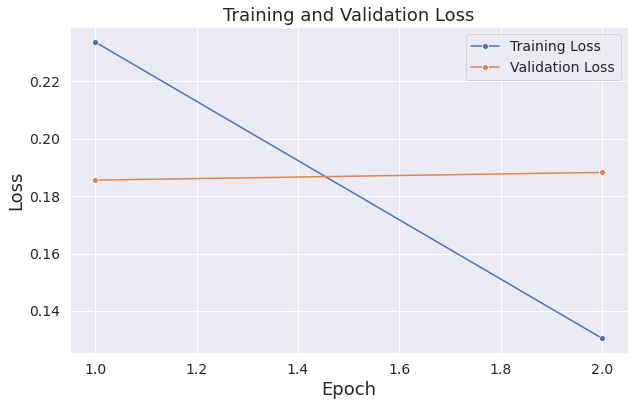

In [ ]:
### Plot Training & Validation Loss
data = {'Epoch': range(1, 3), 'Training Loss': unfreeze_train_loss_values, 'Validation Loss': unfreeze_val_loss_values}
df = pd.DataFrame(data)

fig, ax = plt.subplots(figsize=(10, 6))
sns.set_style('whitegrid')
sns.set(font_scale=1.5)

# Plot train & val loss
sns.lineplot(data=df, x="Epoch", y="Training Loss", label="Training Loss", marker='o')
sns.lineplot(data=df, x="Epoch", y="Validation Loss", label="Validation Loss", marker='o')

# set the axis labels and title
ax.set(xlabel='Epoch', ylabel='Loss')
ax.set_title('Training and Validation Loss', fontsize=18)

# set the legend and adjust its position
plt.legend(fontsize=14)

# set the ticks fontsize
ax.tick_params(axis='both', which='major', labelsize=14)
# ax.grid(True, which='both', linestyle='--', color='lightgray')

In [ ]:
# Predicting with Test Set
unfreeze_test_outputs, unfreeze_test_targets, unfreeze_test_loss, unfreeze_test_time = validate(test_loader, unfreeze_model, criterion, verbose=False)
print('\nEvaluation metrics for Test Set:')
unfreeze_test_f1, unfreeze_test_roc_auc, unfreeze_test_accuracy = compute_metrics(unfreeze_test_outputs, unfreeze_test_targets)


Evaluation metrics for Test Set:
F1 Score 0.9301, ROC AUC 0.9298, Accuracy 0.9298 



In [ ]:
torch.save(unfreeze_model.state_dict(), 'models/DistilBertToxicClassification5.pth')

## 5. DistilBERT 2 hidden layers & Upsampling with Data Augmentation

### Balancing Data with Augmentation

Plan: generate new sentences for the minority class (toxic) by replacing approximately 10% of all words in a given post ($\alpha = 0.1$), using nlpaug library word-level augmentation for DistilBERT 

In [10]:
## HYPER-PARAMETERS BLOCKS
BATCH_SIZE = 16
LR =2e-5
WEIGHT_DECAY = 2e-4
HIDDEN_SIZE = 256
HIDDEN_SIZE2 = 32
DROP_OUT = 0.1
EPOCHS = 2
WORKERS = int(os.cpu_count())

In [11]:
import nlpaug.augmenter.word as nlpaw

def augment_sentence(sentence, aug, num_thread=WORKERS):
    """
    Constructs a new sentence via text augmentation.
    """
    if device == "cuda":
        return aug.augment(sentence, n=1)
    else:
        return aug.augment(sentence, n=1, num_thread=num_thread)
    

In [12]:
# Define nlpaug augmentation object 
aug10p = nlpaw.ContextualWordEmbsAug(model_path='distilbert-base-uncased', 
                                     aug_min=1, 
                                     aug_p=0.1, 
                                     action="substitute",
                                     device='cuda',
                                     batch_size=32
                                    )

In [13]:
list(df[df['label']==0]['comment_text'].values[:5])

['COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK',
 'Hey... what is it..\n@ | talk .\nWhat is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?\n\nAsk Sityush to clean up his behavior than issue me nonsensical warnings...',
 "Bye! \n\nDon't look, come or think of comming back! Tosser.",
 "You are gay or antisemmitian? \n\nArchangel WHite Tiger\n\nMeow! Greetingshhh!\n\nUh, there are two ways, why you do erased my comment about WW2, that holocaust was brutally slaying of Jews and not gays/Gypsys/Slavs/anyone...\n\n1 - If you are anti-semitian, than shave your head bald and go to the skinhead meetings!\n\n2 - If you doubt words of the Bible, that homosexuality is a deadly sin, make a pentagram tatoo on your forehead go to the satanistic masses with your gay pals!\n\n3 - First and last warning, you fucking gay - I won't appreciate if any 

In [14]:
# test augment_sentence output
test_sentences = list(df[df['label']==0]['comment_text'].values[:5])
print('### Test Sentences ###\n',test_sentences)

# augmentation 2 times
num_times = 2
for i in range(num_times):
    new_sentences = augment_sentence(test_sentences, aug10p)
    print(f'\n### Augmentation {i+1} ### \n{new_sentences}')

### Test Sentences ###
 ['COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK', 'Hey... what is it..\n@ | talk .\nWhat is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?\n\nAsk Sityush to clean up his behavior than issue me nonsensical warnings...', "Bye! \n\nDon't look, come or think of comming back! Tosser.", "You are gay or antisemmitian? \n\nArchangel WHite Tiger\n\nMeow! Greetingshhh!\n\nUh, there are two ways, why you do erased my comment about WW2, that holocaust was brutally slaying of Jews and not gays/Gypsys/Slavs/anyone...\n\n1 - If you are anti-semitian, than shave your head bald and go to the skinhead meetings!\n\n2 - If you doubt words of the Bible, that homosexuality is a deadly sin, make a pentagram tatoo on your forehead go to the satanistic masses with your gay pals!\n\n3 - First and last warning, you fucking gay - I won

In [15]:
def augment_text(df, aug, num_threads, num_times):
    """
    Takes a pandas DataFrame, balance the dataset by:
    - Performing undersampling of majority class 
    - Oversampling of minority class with augments its text data.
    
    Input:
        - df:            A pandas DataFrame containing the columns:
                                - 'comment_text' containing strings of text to augment.
                                - 'label' binary target variable containing 0's and 1's.
        - aug:           Augmentation object defined by the nlpaug library.
        - num_threads:   Integer controlling number of threads to use if augmenting
                         text via CPU
        - num_times:     Integer representing the number of times to augment text.
    Output:
        - aug_df:        New DataFrame with augmented data  
                         appended to it and with rows randomly shuffled.
    """
    # Separate majority and minority classes
    df_majority = df[df["label"] == 1][["comment_text", "label"]]
    df_minority = df[df["label"] == 0][["comment_text", "label"]] 

    # Undersample majority class to minority class plus a number of time augumented 
    df_majority_downsampled = resample(df_majority,
                                      replace=False,     # sample without replacement
                                      n_samples=(num_times+1)*round(len(df_minority)), 
                                      random_state=42) 

    # Get rows of data of the minority class to augment
    to_augmentX = list(df_minority['comment_text'].values)
    to_augmentY = np.zeros(len(to_augmentX) * num_times)
    
    # Build up dictionary containing augmented data
    aug_dict = {'comment_text':[], 'label':to_augmentY}
    for i in range(num_times):
        # augX = [augment_sentence(x, aug, num_threads) for x in to_augmentX]
        augX = augment_sentence(to_augmentX, aug, num_threads)
        aug_dict['comment_text'].extend(augX)
    
    # Build DataFrame containing augmented data
    aug_df = pd.DataFrame.from_dict(aug_dict)

    # Add the inital minority df and the new agumented df to the majority downsampled df
    df_majority_downsampled = df_majority_downsampled.append(df_minority, ignore_index=True)
    df_majority_downsampled = df_majority_downsampled.append(aug_df, ignore_index=True)
    df_majority_downsampled['label'] = df_majority_downsampled['label'].astype(int)
    
    return df_majority_downsampled

In [ ]:
# Upsample minority class ('label' == 0) to create a 50-50 class distribution
balanced_df = augment_text(df, aug10p, num_threads=WORKERS, num_times=1)

In [19]:
balanced_df

,comment_text,label
0,"""\n\nOh, don't worry about me, Sandstein. I'm ...",1
1,Are you trying to dispute that fact?,1
2,SWOT analysis \n\nThis source – Align Technolo...,1
3,"cover \n\nso, do we want a current or older co...",1
4,P.S. It's probably worth setting up a template...,1
...,...,...
64895,""" our previous conversation you fucking shit e...",0
64896,you are exhibiting mischievious pubic hair,0
64897,your absurd edits your bullshit edits on great...,0
64898,""" hey listen don't you ever!!!! delete my edit...",0


In [23]:
balanced_df.label.value_counts()

1    32450
0    32450
Name: label, dtype: int64

In [25]:
# Add training data from APPDIA dataset to Jigsaw dataset for fine-tuning
train_file = 'data/original-train.tsv'
df_train_appdia = pd.read_csv(train_file, sep='\t')
df_train_appdia

,offensive-text,style-transferred-text
0,Pussy nobody asked for your input.,Nobody asked for your input
1,"Ok, this makes no sense. This will create vigi...","Ok, this makes no sense. This will create vigi..."
2,so fucking true. the amount of up and coming r...,so true. the amount of up and coming rappers t...
3,Go f yourself Republican scum who put us here ...,Republicans put us in this situation. I would ...
4,Dumb fucking take. People want to do things.,That's not a smart take. People want to do thi...
...,...,...
1579,The View! And this crap hits my front page!? l...,"This must be mostly bots but still, it's stran..."
1580,That’s racist.,Those actions are racist.
1581,Cultural Marxism isn't a thing you weird fuck.,Cultural Marxism isn't a thing.
1582,"LOL, anyone that questions the Democrat progra...","LOL, anyone that questions the Democrat progra..."


In [27]:
# df_balance_copy = balanced_df.copy()

In [38]:
# Add the offensive, toxic texts to the balanced df
toxic_texts = list(df_train_appdia["offensive-text"].values)
toxic_labels = np.zeros(len(toxic_texts))
toxic_df = pd.DataFrame({'comment_text': toxic_texts, 'label': toxic_labels})
balanced_df = balanced_df.append(toxic_df, ignore_index=True)

# Add the annotated non-toxic texts to the balanced df
nontoxic_texts = list(df_train_appdia["style-transferred-text"].values)
nontoxic_labels = np.ones(len(nontoxic_texts))
nontoxic_df = pd.DataFrame({'comment_text': nontoxic_texts, 'label': nontoxic_labels})
balanced_df = balanced_df.append(nontoxic_df, ignore_index=True)

# Shuffle balanced df
balanced_df['label'] = balanced_df['label'].astype(int)
balanced_df = balanced_df.sample(frac=1, random_state=42)
balanced_df = balanced_df.reset_index()
balanced_df = balanced_df[["comment_text", "label"]]

print("Number of class in balanced dataset:")
print(balanced_df['label'].value_counts())
balanced_df

Number of class in balanced dataset:
0    34034
1    34034
Name: label, dtype: int64


,comment_text,label
0,rome is gay \n\nrome is gay i hate rome,0
1,Missed it. Maybe I will make the next (talk),1
2,There's a good test of big bang. Big bang pred...,1
3,major intelligence coup that raised the presti...,1
4,"""Please, sign anything you post here with your...",1
...,...,...
68063,You Suck!\nDear King Shadeed you suck and are ...,0
68064,What was the theme music? \n\nSurely it was no...,1
68065,"if you are having trouble with yourself, then ...",0
68066,"Welcome!\n\nHello, , and welcome to Wikipedia!...",1


In [39]:
# Save balanced dataset to drive
balanced_df.to_csv('data/upsampling_classification_data.csv',sep='\t',index=False)

In [ ]:
# # Clean up text, remove line breaks & special characters
# balanced_df["cleaned_text"] = balanced_df.comment_text.apply(clean_up_text)
# modify_text_to_print(balanced_df[["cleaned_text", "label"]],"cleaned_text")

### Data Splitting & Data Loader

In [40]:
# Split data to train, test, split

## Train, Val, Test Split
X_full = balanced_df["comment_text"]
y_full = balanced_df["label"]

# Split test set
X_train_val, X_test, y_train_val, y_test = train_test_split(X_full, y_full, 
                                                            test_size=0.12,
                                                            random_state=42,
                                                            stratify=y_full
                                                            )

# Split train - dev
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, 
                                                            test_size=0.15,
                                                            random_state=42,
                                                            stratify=y_train_val
                                                            )

In [41]:
print('Train Data Dimension:', X_train.shape)
print('Train Label Dimension:', y_train.shape)
print('Development Data Dimension:', X_val.shape)
print('Development Label Dimension:', y_val.shape)
print('Test Data Dimension:', X_test.shape)
print('Test Label Dimension:', y_test.shape)

Train Data Dimension: (50914,)
Train Label Dimension: (50914,)
Development Data Dimension: (8985,)
Development Label Dimension: (8985,)
Test Data Dimension: (8169,)
Test Label Dimension: (8169,)


In [59]:
# Load the BERT tokenizer
bert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
max_length = 64

def distilBert_loader(X, y, bert_tokenizer, max_length=max_length, batch_size=BATCH_SIZE):
    """
    Convert X, y data to dataloader with tokenizer
    """
    text_encodings = bert_tokenizer(
        list(X.values), 
        max_length=max_length,
        truncation=True,
        pad_to_max_length=True, 
        return_tensors='pt'
    )

    ids = text_encodings.input_ids
    mask = text_encodings.attention_mask
    labels = torch.tensor(y.values)

    dataset = TensorDataset(ids, mask, labels)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=WORKERS)

    return loader

In [60]:
train_loader = distilBert_loader(X_train, y_train, bert_tokenizer, max_length, BATCH_SIZE)
val_loader = distilBert_loader(X_val, y_val, bert_tokenizer, max_length, BATCH_SIZE)
test_loader = distilBert_loader(X_test, y_test, bert_tokenizer, max_length, BATCH_SIZE)

### Fine tuning

In [58]:
# Clear out cuda before training
torch.cuda.empty_cache()

In [61]:
# Initialize model
model = UnfreezeBertClassification(hidden_size=HIDDEN_SIZE, hidden_size2=HIDDEN_SIZE2, dropout=DROP_OUT)
model = model.to(device)


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [62]:
# Initiate loss to Binary Cross Entropy
criterion = nn.BCELoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

# Create learning rate scheduler.
T_max = EPOCHS*len(train_loader)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max)

In [63]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [64]:
# Store the average loss after each epoch so we can plot them.
train_loss_values = []
val_loss_values = []

for epoch in range(EPOCHS):
    print ('######  Epoch {}/{} ######'.format(epoch+1, EPOCHS))
    print ('-----  Training -----')
    train_loss, train_time = train(train_loader, model, criterion, optimizer)
    train_loss_values.append(train_loss)

    print ('-----  Validation -----')
    val_outputs, val_targets, val_loss, val_time = validate(val_loader, model, criterion)
    val_loss_values.append(val_loss)
    val_f1, val_roc_auc, val_accuracy = compute_metrics(val_outputs, val_targets)

######  Epoch 1/2 ######
-----  Training -----
Batch   100  of  3,183.  Loss 0.4324  Elapsed: 0:00:10.
Batch   200  of  3,183.  Loss 0.1438  Elapsed: 0:00:21.
Batch   300  of  3,183.  Loss 0.1775  Elapsed: 0:00:31.
Batch   400  of  3,183.  Loss 0.3012  Elapsed: 0:00:42.
Batch   500  of  3,183.  Loss 0.4235  Elapsed: 0:00:52.
Batch   600  of  3,183.  Loss 0.1614  Elapsed: 0:01:03.
Batch   700  of  3,183.  Loss 0.0787  Elapsed: 0:01:13.
Batch   800  of  3,183.  Loss 0.4487  Elapsed: 0:01:24.
Batch   900  of  3,183.  Loss 0.2866  Elapsed: 0:01:35.
Batch 1,000  of  3,183.  Loss 0.5783  Elapsed: 0:01:46.
Batch 1,100  of  3,183.  Loss 0.0417  Elapsed: 0:01:57.
Batch 1,200  of  3,183.  Loss 0.2396  Elapsed: 0:02:08.
Batch 1,300  of  3,183.  Loss 0.6535  Elapsed: 0:02:19.
Batch 1,400  of  3,183.  Loss 0.4390  Elapsed: 0:02:30.
Batch 1,500  of  3,183.  Loss 0.0719  Elapsed: 0:02:41.
Batch 1,600  of  3,183.  Loss 0.4646  Elapsed: 0:02:52.
Batch 1,700  of  3,183.  Loss 0.1552  Elapsed: 0:03:03.
B

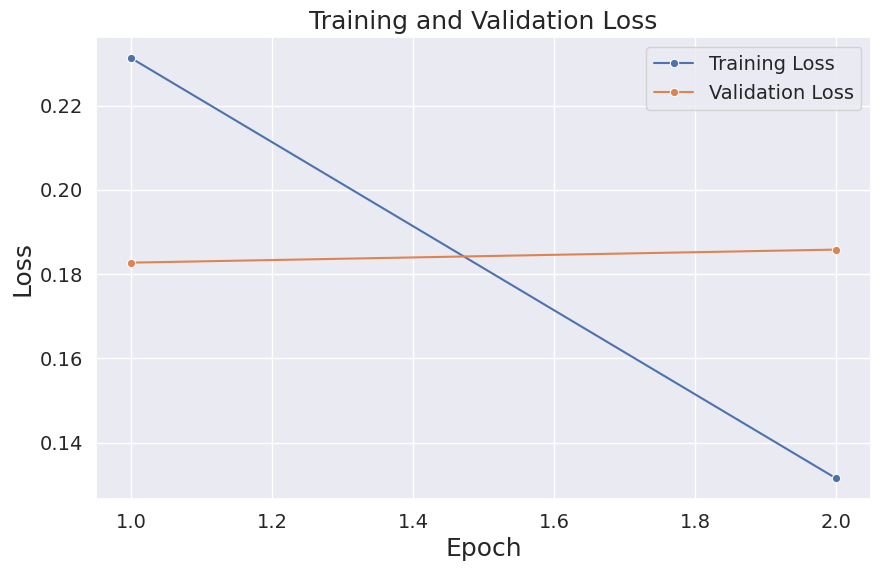

In [65]:
### Plot Training & Validation Loss
data = {'Epoch': range(1, 3), 'Training Loss': train_loss_values, 'Validation Loss': val_loss_values}
df = pd.DataFrame(data)

fig, ax = plt.subplots(figsize=(10, 6))
sns.set_style('whitegrid')
sns.set(font_scale=1.5)

# Plot train & val loss
sns.lineplot(data=df, x="Epoch", y="Training Loss", label="Training Loss", marker='o')
sns.lineplot(data=df, x="Epoch", y="Validation Loss", label="Validation Loss", marker='o')

# set the axis labels and title
ax.set(xlabel='Epoch', ylabel='Loss')
ax.set_title('Training and Validation Loss', fontsize=18)

# set the legend and adjust its position
plt.legend(fontsize=14)

# set the ticks fontsize
ax.tick_params(axis='both', which='major', labelsize=14)

In [66]:
# Predicting with Test Set
test_outputs, test_targets, test_loss, test_time = validate(test_loader, model, criterion, verbose=False)
print('\nEvaluation metrics for Test Set:')
test_f1, test_roc_auc, test_accuracy = compute_metrics(test_outputs, test_targets)


Evaluation metrics for Test Set:
F1 Score 0.9286, ROC AUC 0.9285, Accuracy 0.9285 



In [67]:
torch.save(model.state_dict(), 'models/DistilBertToxicClassification6.pth')